Mount Google Drive if needed:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Installing Dependencies**

In [46]:
import os
HOME = os.getcwd()
print(HOME)

/content/YOLO-V8-CAM


In [47]:
#Install ultralytics

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.9/107.7 GB disk)


In [48]:
from ultralytics import YOLO

from IPython.display import display, Image

In [49]:
import os
import numpy as np
import shutil
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io
import glob
from IPython.display import Image, display


In [55]:
!pip install roboflow
!pip install ttach

## **Clone the EIGEN-CAM Software :**

In [ ]:
%cd /content
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

# **Define Methods**

**Function to trim the image names in the excel files :**

In [32]:
def trim_image_names_inplace(input_excel_file):
    # Read the Excel file into a DataFrame
    df = pd.read_excel(input_excel_file)

    # Modify the "Image Name" column in place by trimming it
    df["Image Name"] = df["Image Name"].str.split("_").str[0]

    # Save the modified DataFrame back to the same Excel file
    df.to_excel(input_excel_file, index=False)

**Function for removing roboflow IDs from the images in dataset:**

In [12]:
def rename_image_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        if "." in file:
            # Split the filename using ".rf." as the separator
            name_parts = file.split(".rf.")
            if len(name_parts) == 2:
                # Extract the actual name and add '.jpg' to the end
                new_name = name_parts[0] + ".jpg"
                # Create the new absolute path for the file
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(folder_path, new_name)
                # Rename the file
                os.rename(old_path, new_path)
                print(f"Renamed: {file} -> {new_name}")

**Function for removing roboflow IDs from the labels in dataset:**

In [13]:
def rename_label_files(folder_path):
    # Get a list of all files in the folder
    files = os.listdir(folder_path)

    for file in files:
        if "." in file:
            # Split the filename using ".rf." as the separator
            name_parts = file.split(".rf.")
            if len(name_parts) == 2:
                # Extract the actual name and add '.jpg' to the end
                new_name = name_parts[0] + ".txt"
                # Create the new absolute path for the file
                old_path = os.path.join(folder_path, file)
                new_path = os.path.join(folder_path, new_name)
                # Rename the file
                os.rename(old_path, new_path)
                print(f"Renamed: {file} -> {new_name}")

**function to classify images and store results in an Excel sheet**

In [14]:
# Define a function to classify images and store results in an Excel sheet
def classify_and_store_results(model, test_directory, output_excel_file):
    # Create an ImageDataGenerator for loading and preprocessing test images
    test_datagen = ImageDataGenerator(rescale=1.0/255.0)  # You may need to adjust preprocessing steps

    # Load and preprocess test images from the test directory
    test_generator = test_datagen.flow_from_directory(
        test_directory,
        target_size=(224, 224),  # Adjust the target size to match your model's input size
        batch_size=1,
        shuffle=False,
        class_mode=None
    )

    # Make predictions on the test images
    predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

    # Get the image names from the generator
    image_names = [os.path.basename(image_path) for image_path in test_generator.filenames]
    # Get the predicted class labels based on the highest probability
    predicted_labels = ["Non-Bleeding" if prediction[1] > prediction[0] else "Bleeding" for prediction in predictions]

    print(predicted_labels)
    # Create a DataFrame to store results
    results_df = pd.DataFrame({'Image Name': image_names, 'Predicted Label': predicted_labels})

    # Save the results to an Excel file
    results_df.to_excel(output_excel_file, index=False)

    # Create folders for Bleeding and Non-Bleeding images
    bleeding_folder = os.path.join(f"{HOME}/classified", "Bleeding_set")
    non_bleeding_folder = os.path.join(f"{HOME}/classified", "Non-Bleeding_set")

    %rm -r {HOME}classified/*
    # Create the folders if they don't exist
    os.makedirs(bleeding_folder, exist_ok=True)
    os.makedirs(non_bleeding_folder, exist_ok=True)

    for image_name, predicted_label in zip(image_names, predicted_labels):
        source_path = os.path.join(test_directory,"1", image_name)
        if predicted_label == "Bleeding":
            destination_path = os.path.join(bleeding_folder, image_name)
        else:
            destination_path = os.path.join(non_bleeding_folder, image_name)

        print(f"Cloning: {source_path} -> {destination_path}")

        # Verify file existence before moving
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
        else:
            print(f"Source file not found: {source_path}")
            # If the source file is not found, move it to the "Non-Bleeding" folder
            shutil.copy(destination_path, source_path)

    return bleeding_folder


**function to extract YOLO labels and confidence from .txt label files and update the Excel file**

In [15]:
# Define a function to extract YOLO labels and confidence from .txt files and update the Excel file
def update_excel_with_yolo_labels(excel_file, yolo_labels_dir):
    # Read the existing Excel file
    results_df = pd.read_excel(excel_file)

    new_rows = []  # To store new rows to be added to the DataFrame

    # Iterate over the rows in the DataFrame
    for index, row in results_df.iterrows():
        image_name = row['Image Name']
        predicted_label = row['Predicted Label']

        # Check if the image was classified as "Bleeding"
        if predicted_label == "Bleeding":
            # Construct the path to the corresponding YOLO label file
            yolo_label_file = os.path.join(yolo_labels_dir, image_name.replace('.jpg', '.txt'))

            # Check if the YOLO label file exists
            if os.path.isfile(yolo_label_file):
                with open(yolo_label_file, 'r') as f:
                    lines = f.readlines()

                # Extract YOLO label information
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) == 6:
                        class_id, x_center, y_center, width, height, confidence = parts
                        yolo_labels = {
                            'Image Name': image_name,
                            'X_Center': float(x_center),
                            'Y_Center': float(y_center),
                            'Width': float(width),
                            'Height': float(height),
                            'Confidence': float(confidence)
                        }
                        new_rows.append(yolo_labels)

    # Create a DataFrame from the new rows
    yolo_labels_df = pd.DataFrame(new_rows)

    # Merge the original DataFrame with the new DataFrame based on the 'Image Name' column
    merged_df = pd.merge(results_df, yolo_labels_df, on='Image Name', how='left')

    # Save the merged DataFrame back to the Excel file
    merged_df.to_excel(excel_file, index=False)


**Function to generate Eigen-CAM for an image**

In [16]:
# Function to generate Eigen-CAM for an image
def generate_eigen_cam_for_image(model, image_path, target_layers):
    # Load and preprocess the image
    plt.rcParams["figure.figsize"] = [3.0, 3.0]
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    rgb_img = img.copy()
    img = np.float32(img) / 255

    # Create Eigen-CAM object
    cam = EigenCAM(model, target_layers, task='od')

    # Generate Eigen-CAM
    grayscale_cam = cam(rgb_img)[0, :, :]

    # Overlay Eigen-CAM on the original image
    cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    return cam_image


**Function to generate Eigen-CAM for a folder of images**

In [17]:
# Function to generate Eigen-CAM for a folder of images
def generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of image file paths in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]

    for image_file in image_files:
        image_path = os.path.join(input_folder, image_file)

        # Generate Eigen-CAM for the image
        cam_image = generate_eigen_cam_for_image(model, image_path, target_layers)

        # Save the CAM image to the output folder with the same name
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, cam_image)

# **Install the Test datasets**

**Uploaded the test sets to roboflow for easy access and converting them to one single format (.jpg)**

**Folder Structure Example:**

>     Test_dataset_n-1:
                      1:
                        img_1.jpg
                        img_2.jpg
                        img_3.jpg

**Test Dataset 1:**

In [18]:
from roboflow import Roboflow
rf = Roboflow(api_key="cKn8EJuXFYdKbWUJpIjO")
project = rf.workspace("team-scgyk").project("test_dataset_1-xirlt")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Test_Dataset_1-1 in folder:: 100%|██████████| 53/53 [00:00<00:00, 4943.58it/s]


**Test Dataset 2:**

In [19]:
from roboflow import Roboflow
rf = Roboflow(api_key="cKn8EJuXFYdKbWUJpIjO")
project = rf.workspace("team-scgyk").project("test_dataset_2-rubaw")
dataset = project.version(1).download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Test_Dataset_2-1 in folder:: 100%|██████████| 514/514 [00:00<00:00, 8603.25it/s]


Remove the roboflow IDs from the images of both the tes datasets dataset:

In [20]:
# Provide the folder path here
folder_path = "/content/Test_Dataset_1-1/test/1"
rename_image_files(folder_path)
folder_path = "/content/Test_Dataset_2-1/test/1"
rename_image_files(folder_path)

Renamed: A0035_png.rf.1abb150b7fe2536d47eff256b9fd3157.jpg -> A0035_png.jpg
Renamed: A0025_png.rf.8ec7be364034c18c361a718896357db2.jpg -> A0025_png.jpg
Renamed: A0013_png.rf.d3da728e091a6a2934f997df59d9113d.jpg -> A0013_png.jpg
Renamed: A0006_png.rf.b3defa128d185631f5bdf7179ca07027.jpg -> A0006_png.jpg
Renamed: A0047_png.rf.656c16c0167f49b3b1b42d68ee6e1d7c.jpg -> A0047_png.jpg
Renamed: A0036_png.rf.7fc11a714eba141d5c3ef80986f7767f.jpg -> A0036_png.jpg
Renamed: A0031_png.rf.06c7776df75b067f982155a1c2c01994.jpg -> A0031_png.jpg
Renamed: A0005_png.rf.d119e3bd678390867e25cebff943cc3e.jpg -> A0005_png.jpg
Renamed: A0028_png.rf.e0b420500e1b5f0aa4c64329d246da5d.jpg -> A0028_png.jpg
Renamed: A0016_png.rf.2f7a8cff83e3300c64b89860ce0a0e20.jpg -> A0016_png.jpg
Renamed: A0049_png.rf.df027c7a633c81f27bee8ad07f6821d6.jpg -> A0049_png.jpg
Renamed: A0008_png.rf.badd7b0bc9a949045a96d0a367ca1bb4.jpg -> A0008_png.jpg
Renamed: A0029_png.rf.982fc504e0880ac278a7871dc8c4d52a.jpg -> A0029_png.jpg
Renamed: A00

# **Testing on Test -1**

In [21]:

if __name__ == "__main__":
    # Load your trained model
    model = tf.keras.models.load_model('/content/drive/MyDrive/S3N/weights/model_cls.h5')  # Replace with your classification model file

    # Specify the directory containing test images
    test_directory = '/content/Test_Dataset_1-1/test/'  # Replace with your test image directory
    %mkdir -p excel
    # Specify the name of the output Excel file
    output_excel_file = '/content/excel/test-1.xlsx'  # Change this to your desired output file name

    # Call the function to classify images and store results in Excel
    path=classify_and_store_results(model, test_directory, output_excel_file)

    %cp /content/excel/test-1.xlsx /content/excel/test-1_with_yolo_bbox.xlsx

    #detect with yolo model on the classified bleeding folder
    %cd /content
    %rm -r runs/detect/predict #delete preexisting unnecessary folder
    !yolo task=detect mode=predict model=/content/drive/MyDrive/WCEBLEEDGen/weights/runs/detect/train2/weights/best.pt conf=0.06 source={path} save=True save_txt=True save_conf=True nms=True agnostic_nms=True

    yolo_labels_dir = 'runs/detect/predict/labels'  # Replace with the directory containing YOLO label files
    output_excel_file = '/content/excel/test-1_with_yolo_bbox.xlsx'

    # Call the function to update the Excel file with YOLO labels
    update_excel_with_yolo_labels(output_excel_file, yolo_labels_dir)

    print(f"YOLO labels updated in {output_excel_file}")
    print("Results stored in", output_excel_file)


Found 49 images belonging to 1 classes.
49/49 [==============================] - 5s 69ms/step
['Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding']
rm: cannot remove '/contentclassified/*': No such file or directory
Cloning: /content/Test_Dataset_1-1/test/1/A0000_png.jpg -> /content/classified/Bleeding_set/A0000_png.jpg
Cloning: /content/Test_Dataset_1-1/test/1/A0001_png.jpg -> /content/classified/Bleeding_set/A0001_png.jpg
Cloning: /content/Test_Dataset_1-1/te

**Trim the Image Names in Excel files:**

In [35]:
input_excel_file = "/content/excel/test-1.xlsx"  #input Excel file path
trim_image_names_inplace(input_excel_file)

input_excel_file = "/content/excel/test-1_with_yolo_bbox.xlsx"  #input Excel file path
trim_image_names_inplace(input_excel_file)

## **Generate Eigen-CAM on a folder:**

In [24]:
%cd /content/YOLO-V8-CAM
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

/content/YOLO-V8-CAM


In [28]:
# Load your trained model
model = YOLO('/content/drive/MyDrive/S3N/weights/best.pt')

# Specify the input and output folders
input_folder = os.path.join(f'{path}')   # Replace with your input image folder
output_folder = f'{HOME}/eigen_cam_output/test_dataset_1'  # Replace with your output image folder

# Specify the target layers for Eigen-CAM
target_layers = [model.model.model[-2]]

# Generate Eigen-CAM for the folder of images and save them
generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers)
print("Eigen-CAM images saved in", output_folder)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


Eigen-CAM images saved in /content/eigen_cam_output/test_dataset_1


**Visualize a few of the Eigen-Cam Images from the output folder:**

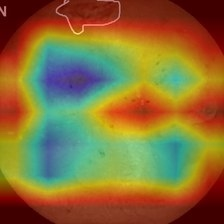


 A0023_png.jpg


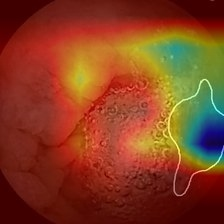


 A0041_png.jpg


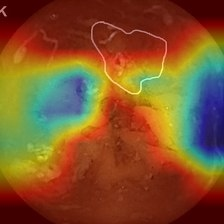


 A0009_png.jpg


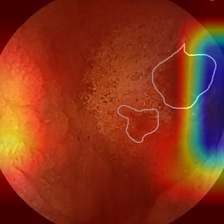


 A0042_png.jpg


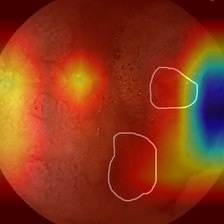


 A0043_png.jpg


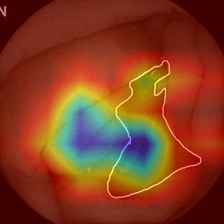


 A0012_png.jpg


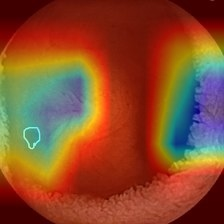


 A0032_png.jpg


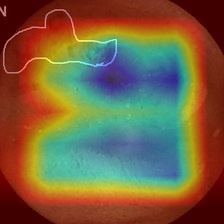


 A0021_png.jpg


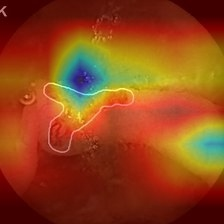


 A0046_png.jpg


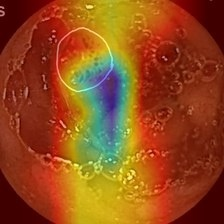


 A0001_png.jpg


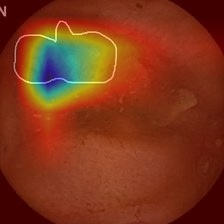


 A0020_png.jpg


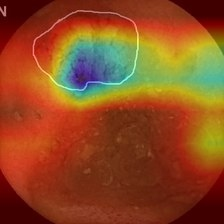


 A0026_png.jpg


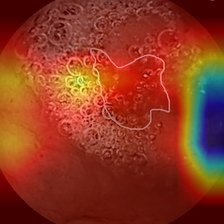


 A0038_png.jpg


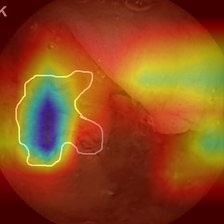


 A0044_png.jpg


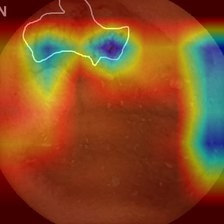


 A0028_png.jpg


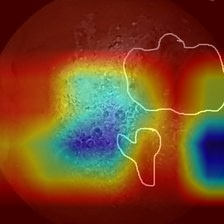


 A0040_png.jpg


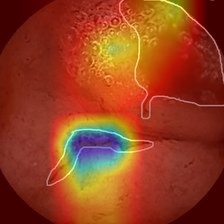


 A0036_png.jpg


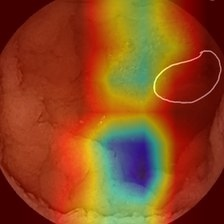


 A0002_png.jpg


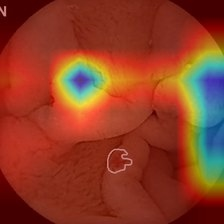


 A0017_png.jpg


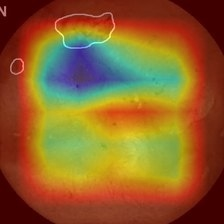


 A0007_png.jpg


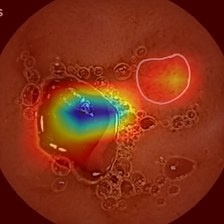


 A0003_png.jpg


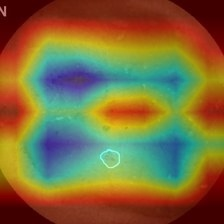


 A0029_png.jpg


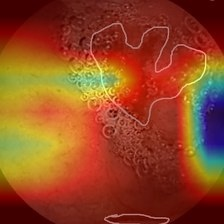


 A0039_png.jpg


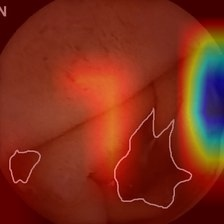


 A0011_png.jpg


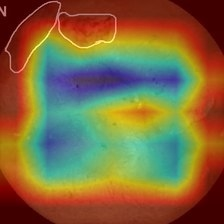


 A0022_png.jpg


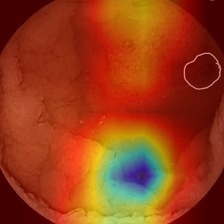


 A0000_png.jpg


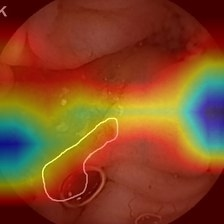


 A0048_png.jpg


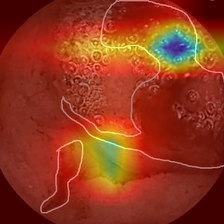


 A0037_png.jpg


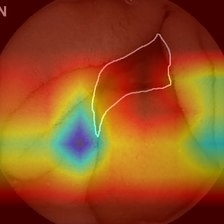


 A0013_png.jpg


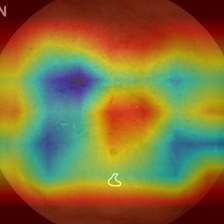


 A0030_png.jpg


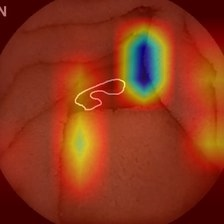


 A0014_png.jpg


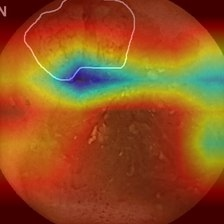


 A0025_png.jpg


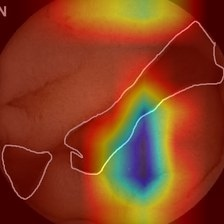


 A0010_png.jpg


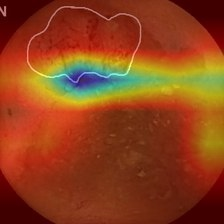


 A0027_png.jpg


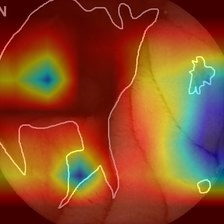


 A0031_png.jpg


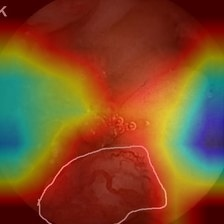


 A0047_png.jpg


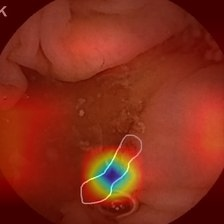


 A0049_png.jpg


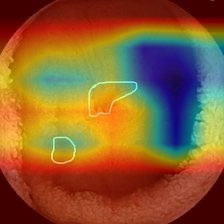


 A0033_png.jpg


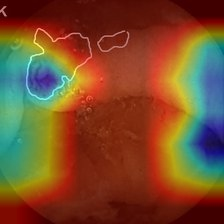


 A0045_png.jpg


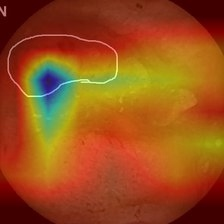


 A0006_png.jpg


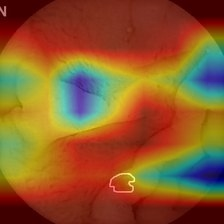


 A0016_png.jpg


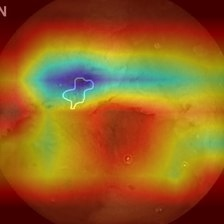


 A0004_png.jpg


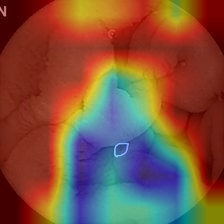


 A0018_png.jpg


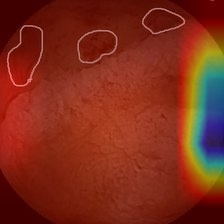


 A0035_png.jpg


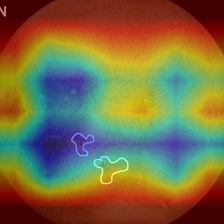


 A0005_png.jpg


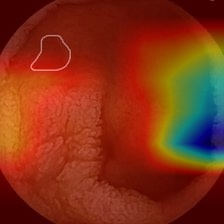


 A0034_png.jpg


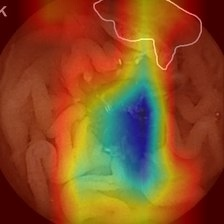


 A0008_png.jpg


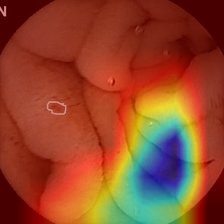


 A0019_png.jpg


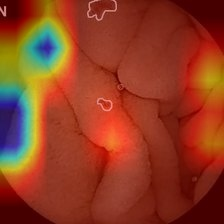


 A0024_png.jpg


In [30]:
for image_path in glob.glob(f'{output_folder}/*.jpg')[:50]:
      display(Image(filename=image_path, width=200))
      # Extract and print the image name
      image_name = os.path.basename(image_path)
      print(f"\n {image_name}")

# **Testing on Test Dataset 2**

In [37]:

if __name__ == "__main__":
    # Load your trained model
    model = tf.keras.models.load_model('/content/drive/MyDrive/WCEBLEEDGen/model_cls.h5')  # Replace with your classification model file

    # Specify the directory containing test images
    test_directory = '/content/Test_Dataset_2-1/test/'  # Replace with your test image directory
    %mkdir -p excel
    # Specify the name of the output Excel file
    output_excel_file = '/content/excel/test-2.xlsx'  # Change this to your desired output file name

    # Call the function to classify images and store results in Excel
    path=classify_and_store_results(model, test_directory, output_excel_file)

    %cp /content/excel/test-2.xlsx /content/excel/test-2_with_yolo_bbox.xlsx

    #detect with yolo model on the classified bleeding folder
    %cd /content
    %rm -r runs/detect/predict #delete preexisting unnecessary folder
    !yolo task=detect mode=predict model=/content/drive/MyDrive/WCEBLEEDGen/weights/runs/detect/train2/weights/best.pt conf=0.06 source={path} save=True save_txt=True save_conf=True nms=True agnostic_nms=True

    yolo_labels_dir = 'runs/detect/predict/labels'  # Replace with the directory containing YOLO label files
    output_excel_file = '/content/excel/test-2_with_yolo_bbox.xlsx'

    # Call the function to update the Excel file with YOLO labels
    update_excel_with_yolo_labels(output_excel_file, yolo_labels_dir)

    print(f"YOLO labels updated in {output_excel_file}")
    print("Results stored in", output_excel_file)


Found 510 images belonging to 1 classes.
510/510 [==============================] - 46s 84ms/step
['Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', 'Bleeding', '

**Trim the Image Names in Excel files:**

In [45]:
input_excel_file = "/content/excel/test-2.xlsx"  #input Excel file path
trim_image_names_inplace(input_excel_file)

input_excel_file = "/content/excel/test-2_with_yolo_bbox.xlsx"  #input Excel file path
trim_image_names_inplace(input_excel_file)

## **Generate Eigen-CAM on a folder:**

In [51]:
%cd /content/YOLO-V8-CAM
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

/content/YOLO-V8-CAM


In [39]:
# Load your trained model
model = YOLO('/content/drive/MyDrive/WCEBLEEDGen/weights/runs/detect/train2/weights/best.pt')

# Specify the input and output folders
input_folder = os.path.join(f'{path}') # Replace with your input image folder
output_folder = f'{HOME}/eigen_cam_output/test_dataset_2'  # Replace with your output image folder

%rm -r {output_folder} #remove unnecessary pre-existing folder
!mkdir {output_folder}
# Specify the target layers for Eigen-CAM
target_layers = [model.model.model[-2]]

# Generate Eigen-CAM for the folder of images and save them
generate_eigen_cam_for_folder(model, input_folder, output_folder, target_layers)
print("Eigen-CAM images saved in", output_folder)

rm: cannot remove '/content/eigen_cam_output/test_dataset_2': No such file or directory


Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


Eigen-CAM images saved in /content/eigen_cam_output/test_dataset_2


**Visualize a few of the Eigen-Cam Images from the output folder:**

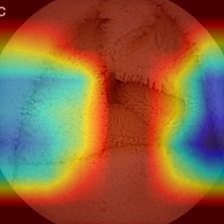


 A0330_png.jpg


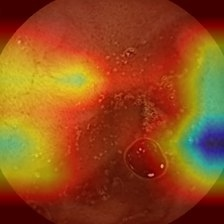


 A0459_png.jpg


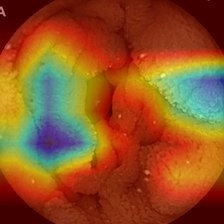


 A0078_png.jpg


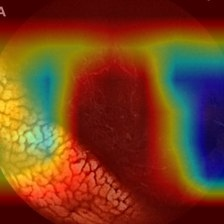


 A0158_png.jpg


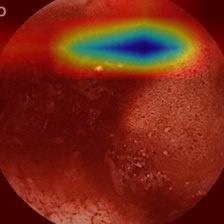


 A0352_png.jpg


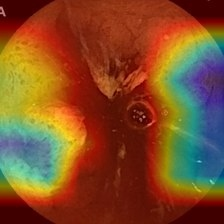


 A0239_png.jpg


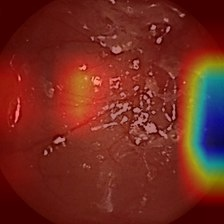


 A0464_png.jpg


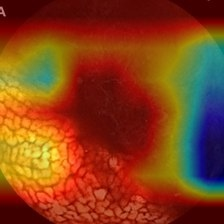


 A0155_png.jpg


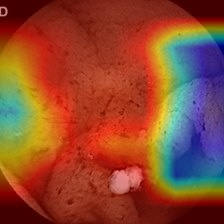


 A0380_png.jpg


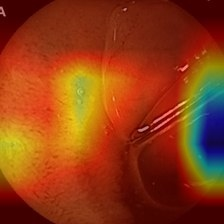


 A0120_png.jpg


In [54]:
for image_path in glob.glob(f'{output_folder}/*.jpg')[:10]:
      display(Image(filename=image_path, width=200))
      # Extract and print the image name
      image_name = os.path.basename(image_path)
      print(f"\n {image_name}")